# Exploring Dandiset 001433: Breathing Rhythm and Place Dataset

*This notebook was generated with the assistance of AI. Please review all code and results carefully and use your own judgment when interpreting or extending any analyses presented here.*

---

## Overview

[Dandiset 001433](https://dandiarchive.org/dandiset/001433/0.250507.2356) contains behavioral and electrophysiological data from freely moving mice. The dataset includes:

- Simultaneous local field potential (LFP) recordings from the olfactory bulb (16 electrodes)
- Sniffing/respiration voltage signal (single channel, via thermistor)
- Processed behavioral events: inhalation and exhalation times

No experimental task, reward, or imposed stimulus is present—mice were recorded during natural behavior.

The files are stored in NWB format and each session typically includes:
- Raw LFP
- Sniff signal
- Behavioral event times (inhalation/exhalation)
- Complete subject and recording metadata

For more details, see the [DANDI repository](https://dandiarchive.org/dandiset/001433/0.250507.2356).

---

## What this notebook covers

- Summarizing the Dandiset and its main features
- Browsing NWB files in the Dandiset using the DANDI API
- Loading and extracting data from an NWB file via remote streaming (no local download)
- Visualizing LFP channels and sniff signal
- Overlaying inhalation and exhalation behavioral events on the sniffing trace
- Describing the overall data organization and the contents of a typical file

## Required Packages

This notebook assumes the following packages are installed:

- numpy
- matplotlib
- dandi
- pynwb
- h5py
- remfile

Please ensure these dependencies are available in your environment.

## 1. DANDI API: Browsing NWB files in the Dandiset

We start by listing a few NWB files available in this Dandiset using the DANDI API.
This step demonstrates how to programmatically access metadata and file listings.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Specify Dandiset ID and version
dandiset_id = "001433"
dandiset_version = "0.250507.2356"

# Initialize DANDI client and fetch the Dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List the first 10 NWB files by their asset path
nwb_assets = dandiset.get_assets_by_glob("*.nwb")
nwb_files = [asset.path for asset in islice(nwb_assets, 10)]

print("Example NWB files in this Dandiset:")
for fname in nwb_files:
    print("-", fname)

Example NWB files in this Dandiset:
- sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb
- sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb
- sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T152953_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153010_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153020_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153032_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153048_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153100_ecephys.nwb


## 2. Loading and Exploring a Session NWB File

In the following sections, we focus on a representative recording session:

**sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb**

We will extract:
- LFP time series (all 16 channels)
- Sniffing (thermistor) signal
- Inhalation and exhalation event times (behavior module)

Data will be streamed remotely using `remfile` rather than downloaded.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pynwb
import h5py
import remfile

# Always close files after use in a real workflow.
# Here we open the file for demonstration and exploration.

nwb_path = "sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb"

# Find the download URL for remote streaming
asset = next(dandiset.get_assets_by_glob(nwb_path))
url = asset.download_url

# Open NWB file remotely via remfile and h5py
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

print("Loaded NWB file:", nwb_path)
print("Session description:", nwb.session_description)
print("Subject ID:", nwb.subject.subject_id)
print("Session start time:", nwb.session_start_time)

Loaded NWB file: sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb
Session description: LFP and sniff recording
Subject ID: 4122
Session start time: 2025-05-07 15:29:27.359523-07:00


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Quick Summary of File Structure
* LFP: 16-channel signal, olfactory bulb, 1000 Hz sampling
* SniffSignal: single-channel, thermistor voltage, 1000 Hz sampling
* Behavioral module: inhalation/exhalation event times (in milliseconds, convert to seconds)
* All metadata is in standard NWB tables

## 3. LFP and Sniff Signal: First 10 Seconds Visualization

Let's extract the first 10 seconds from both the LFP (channel 0 for clarity) and sniffing trace, and visualize them.

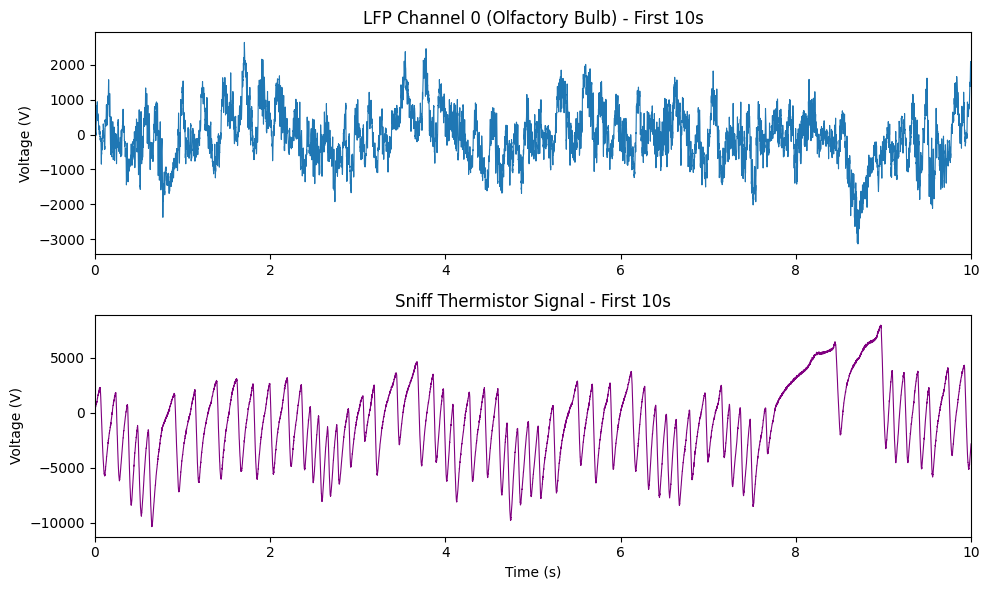

In [3]:
# Parameters
duration_sec = 10

# -- LFP signal --
lfp = nwb.acquisition['LFP']
sample_rate = int(lfp.rate)  # expected 1000 Hz
n_samples = duration_sec * sample_rate

lfp_data = lfp.data[:n_samples, :]      # shape: (samples, channels)
lfp_time = np.arange(n_samples) / sample_rate

# -- Sniff signal --
sniff = nwb.acquisition['SniffSignal']
sniff_data = sniff.data[:n_samples]     # shape: (samples,)
sniff_time = np.arange(n_samples) / sample_rate

# Plot: LFP channel 0 and sniff trace
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(lfp_time, lfp_data[:, 0], lw=0.8)
plt.title('LFP Channel 0 (Olfactory Bulb) - First 10s')
plt.ylabel('Voltage (V)')
plt.xlim([0, duration_sec])

plt.subplot(2, 1, 2)
plt.plot(sniff_time, sniff_data, color='purple', lw=0.8)
plt.title('Sniff Thermistor Signal - First 10s')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.xlim([0, duration_sec])

plt.tight_layout()
plt.show()

## 4. Inhalation and Exhalation Timing Events

The behavioral processing module contains event times for inhalation and exhalation.
These are stored as NWB TimeSeries objects, with event times in milliseconds (ms).

We'll convert them to seconds and overlay them on the sniff trace for the first 10 seconds.

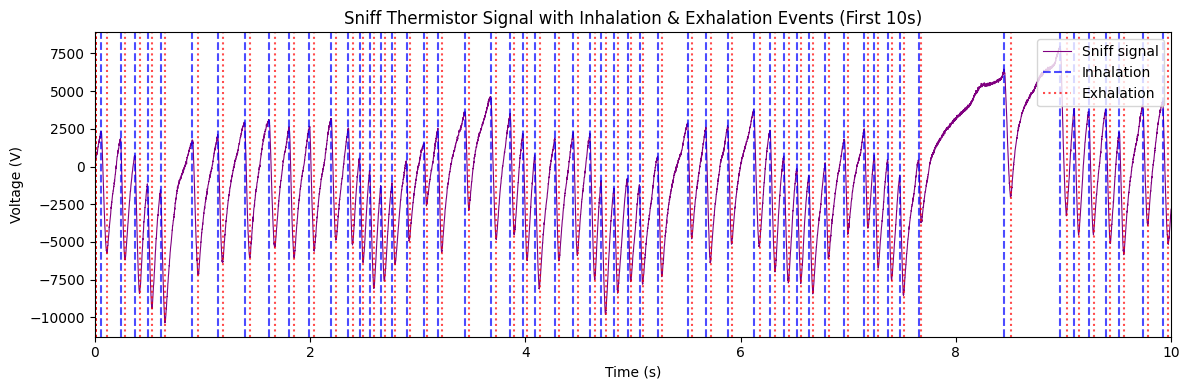

In [4]:
# Access behavior processing module and event time series
behavior_mod = nwb.processing['behavior']
inhalation = behavior_mod.data_interfaces['inhalation_time']
exhalation = behavior_mod.data_interfaces['exhalation_time']

# Convert inhalation/exhalation event times from ms to seconds
inhalation_times_sec = inhalation.timestamps[:] / 1000.0
exhalation_times_sec = exhalation.timestamps[:] / 1000.0

# Retain events within the first 10 seconds
inhale_times_plot = inhalation_times_sec[inhalation_times_sec <= duration_sec]
exhale_times_plot = exhalation_times_sec[exhalation_times_sec <= duration_sec]

# Plot sniff trace with overlaid inhalation (blue dashed) and exhalation (red dotted) events
plt.figure(figsize=(12, 4))
plt.plot(sniff_time, sniff_data, color='purple', lw=0.8, label='Sniff signal')
for idx, t in enumerate(inhale_times_plot):
    plt.axvline(x=t, color='b', alpha=0.7, linestyle='--', label='Inhalation' if idx == 0 else "")
for idx, t in enumerate(exhale_times_plot):
    plt.axvline(x=t, color='r', alpha=0.7, linestyle=':', label='Exhalation' if idx == 0 else "")

plt.title('Sniff Thermistor Signal with Inhalation & Exhalation Events (First 10s)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim([0, duration_sec])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 5. Other Data and Metadata in the NWB File

- **No spike-sorting results or units table** are included in this file.
- **No additional behavioral modules** beyond the `behavior` module for breathing event times.
- **Acquisition** is limited to LFP and sniffing signals.
- **Device, electrode, and electrode group tables** provide standard metadata (OpenEphys system, 16 LFP electrodes in olfactory bulb).
- **Subject and session metadata** (subject ID: 4122, sex: M, age: P90D, species: Mus musculus) are standard and included.
- **No video data or external experimental annotations** are included.

This structure is typical for all files in this Dandiset.

---

## Summary

This notebook demonstrated:
- How to use the DANDI API to explore available NWB files remotely
- How to access and visualize LFP, sniffing, and behavioral breathing events through streaming
- The metadata concept and overall organizational structure for Dandiset 001433

**You are now ready to adapt this workflow to other sessions, channels, or types of analysis!**  

For further exploration, consider:
- Analyzing LFP across all 16 channels
- Investigating timing relationships between LFP oscillations and the respiration cycle
- Detecting and analyzing specific behaviors, or extracting epochs of interest from the sniffing/LFP signals